In [50]:
# IMPORTING THE LIBRARIES
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
import plotly.express as px
import matplotlib.pyplot as plt


# 1 Exploratory Data Analysis

#### In this part we will explore the data and understand the different variables

In [51]:
insp = pd.read_csv("inspections.csv")
network = pd.read_csv("network.csv")
samplesub = pd.read_csv("sample_submission.csv")

In [52]:
finalsub = samplesub.merge(network, how='inner', on='PipeId')
finalsub
keep_columns_sub = ['YearBuilt', 'Diameter', 'Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder']
finalsub_simple = finalsub[keep_columns_sub]
finalsub_simple

,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder
0,2012,110.0,44.286,0.150,0,0
1,2012,160.0,110.715,0.150,2,0
2,2012,110.0,13.575,0.150,0,0
3,2012,110.0,327.689,0.150,3,0
4,2007,200.0,932.762,0.150,0,0
...,...,...,...,...,...,...
909728,2004,110.0,7.656,0.025,0,0
909729,2004,110.0,4.383,0.025,2,0
909730,2004,110.0,2.292,0.025,1,0
909731,2004,90.0,87.809,4.000,0,0


In [53]:
counts = network["Material"].value_counts()
fig = px.bar(counts, x=counts.index, y=counts.values, labels={"x": "Value", "y": "Count"})
fig.show()

In [54]:
merged_df = pd.merge(insp, network, on='PipeId')
final_df = pd.merge(merged_df, samplesub, on='PipeId')
final_df.describe()

,PipeId,InspectionYear,MonthsLastRev,Severity,Incidence_x,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,Incidence_y
count,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06,3.976947e+06
mean,2.016358e+08,2.015492e+03,2.312203e+01,3.997402e+00,1.943199e-03,2.000845e+03,1.202366e+02,3.768914e+01,2.676459e+00,1.034012e+00,2.039253e-04,1.949234e-03
std,1.128346e+08,2.842452e+00,4.233757e+00,6.517493e-02,4.403889e-02,1.201994e+01,5.724771e+01,7.189253e+01,5.789699e+00,2.203119e+00,1.524956e-02,4.410708e-02
min,4.897800e+05,2.010000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.901000e+03,1.000000e+01,6.000000e-03,2.500000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.335387e+08,2.013000e+03,2.300000e+01,4.000000e+00,0.000000e+00,1.997000e+03,9.000000e+01,4.721000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.902723e+08,2.015000e+03,2.400000e+01,4.000000e+00,0.000000e+00,2.003000e+03,1.100000e+02,1.543900e+01,1.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.974200e+08,2.018000e+03,2.400000e+01,4.000000e+00,0.000000e+00,2.007000e+03,1.600000e+02,4.603400e+01,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,4.519953e+08,2.020000e+03,1.320000e+02,4.000000e+00,1.000000e+00,2.050000e+03,6.096000e+02,7.281373e+03,8.000000e+01,8.800000e+01,3.000000e+00,1.000000e+00


C:\Users\zonca\AppData\Local\Temp\ipykernel_11844\3588651141.py:3: FutureWarning:

The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()



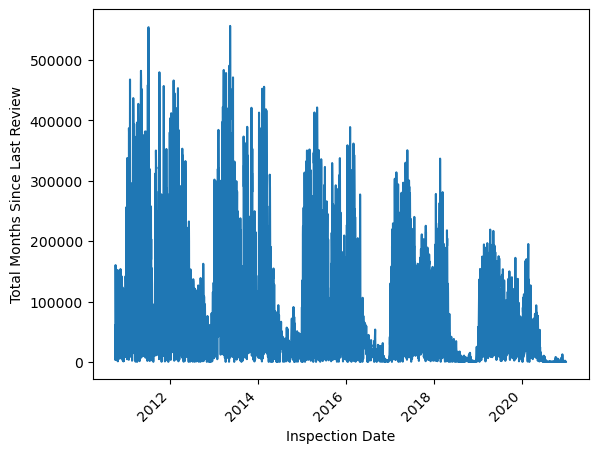

In [55]:
final_df = final_df.sort_values('InspectionDate')
final_df['InspectionDate'] = pd.to_datetime(final_df['InspectionDate'])
final_df['MonthsLastRev'] = (pd.to_datetime('now') - final_df['InspectionDate']) / pd.Timedelta(days=30)
grouped_data = final_df.groupby('InspectionDate')['MonthsLastRev'].sum().reset_index()
plt.plot(grouped_data['InspectionDate'], grouped_data['MonthsLastRev'])
plt.xlabel('Inspection Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Months Since Last Review')
plt.show()

C:\Users\zonca\AppData\Local\Temp\ipykernel_11844\2375973590.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



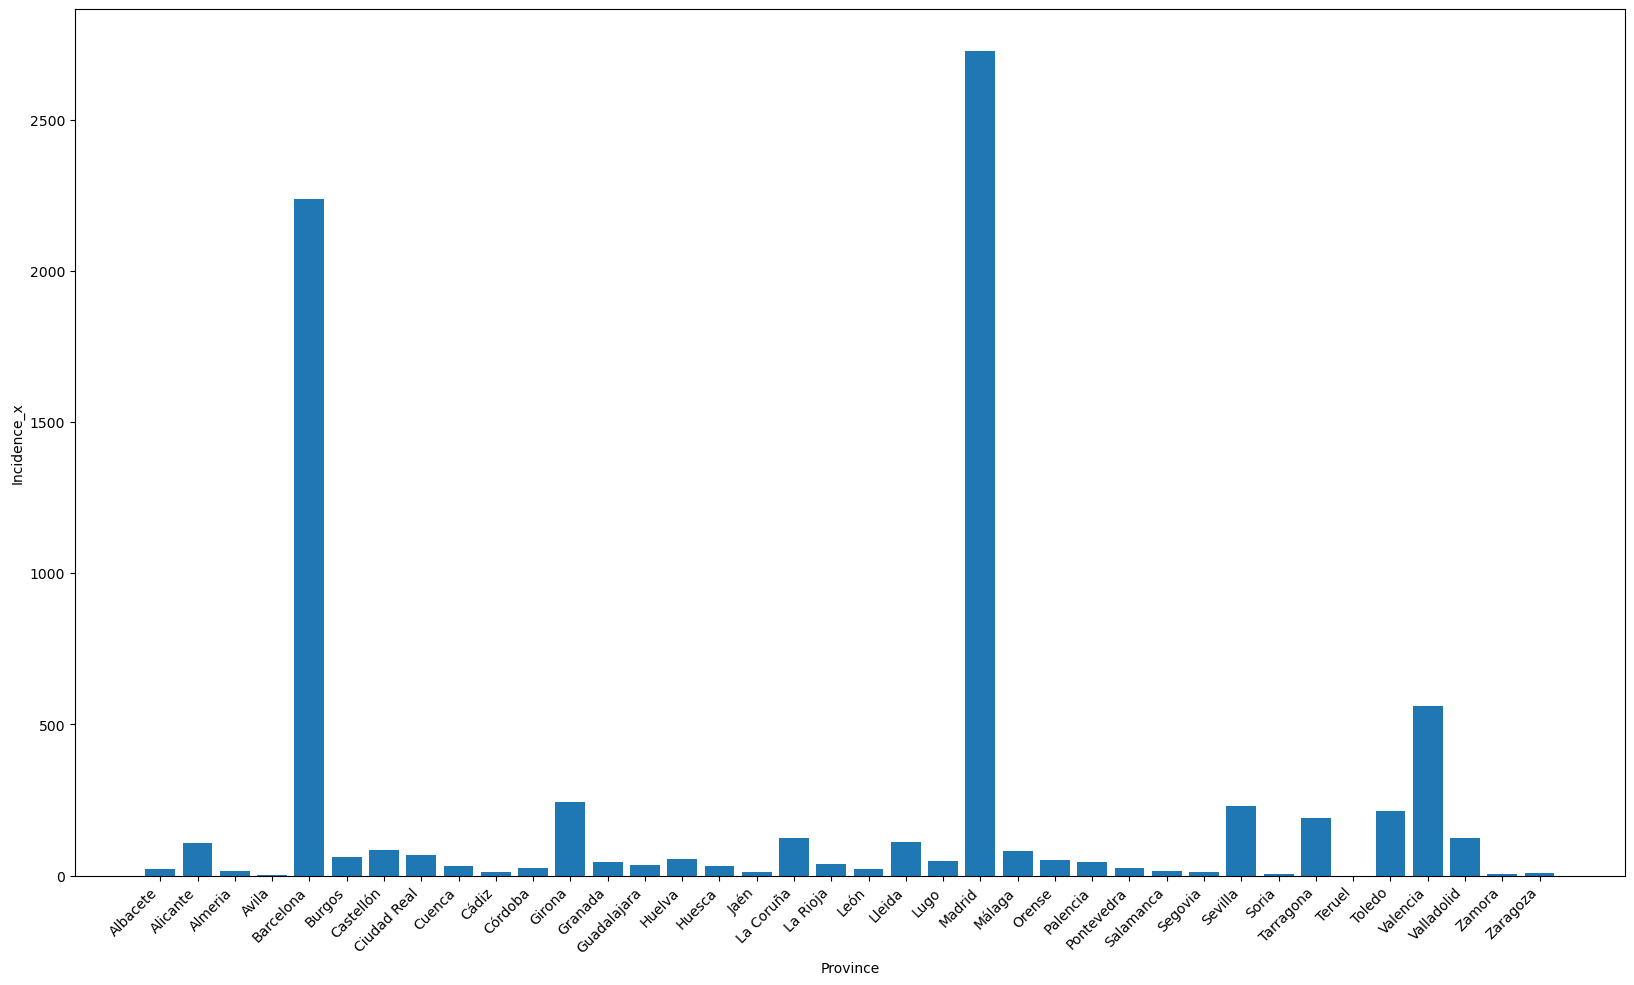

In [56]:
grouped_data = final_df.groupby('Province')['Incidence_x'].sum().reset_index()
fig = plt.figure(figsize=(1920/96, 1080/96))
ax = fig.add_subplot(111)
ax.bar(grouped_data['Province'], grouped_data['Incidence_x'])
ax.set_xlabel('Province')
ax.set_xticklabels(grouped_data['Province'], rotation=45, ha='right')
ax.set_ylabel('Incidence_x')
plt.show()

C:\Users\zonca\AppData\Local\Temp\ipykernel_11844\3319985792.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



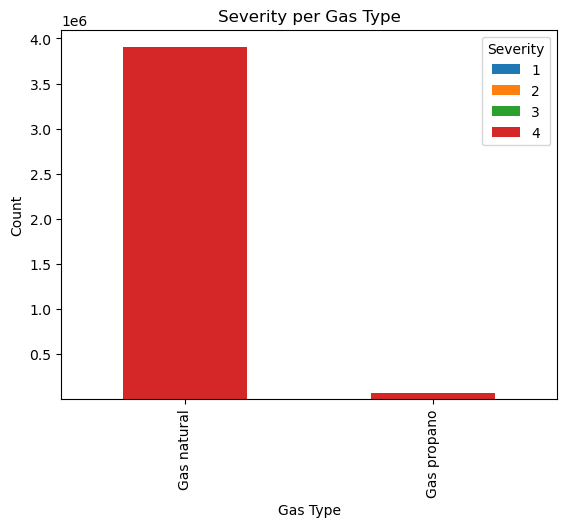

In [57]:
grouped_data = final_df.groupby(['GasType', 'Severity']).sum().reset_index()
grouped_data = final_df.groupby(['GasType', 'Severity']).size().reset_index(name='count')
pivoted_data = grouped_data.pivot(index='GasType', columns='Severity', values='count')
pivoted_data.plot(kind='bar', stacked=True)
plt.title('Severity per Gas Type')
plt.xlabel('Gas Type')
plt.ylabel('Count')
plt.show()

# 2 Feature engineering

#### Here we will create the final dataframes that we will use to train our model, we will have 3 final datasets consisting of the whole training data (without target), the training target and the submission data for which we will generate the predictions, first we will start by importing the libraries, merging the different datasets between them and droping, renaming and generating new columns to obtain our desired outcome

In [58]:
# READING THE DATA
insp = pd.read_csv("inspections.csv")
network = pd.read_csv("network.csv")
samplesub = pd.read_csv("sample_submission.csv")

In [59]:
# INCORPORATING THE FEATURES IN NETWORK TO OUR SUBMISSION FILE
samplesub = samplesub.merge(network, how="left", on="PipeId")

In [60]:
# INCORPORATING THE FEATURES IN NETWORK TO OUR TRAINING DATA
insp = insp.merge(network, how ="inner", on = "PipeId")

In [61]:
# DROPPING UNNECESARY COLUMNS
insp = insp.drop("InspectionDate", axis=1)
insp = insp.drop("MaintenanceId", axis=1)

In [62]:
# FEATURE CREATION
insp["AgeWhenInspected"] = insp["InspectionYear"] - insp["YearBuilt"]

In [63]:
# DROPPING UNNECESARY COLUMNS
insp_pure = insp.drop(columns=["Province","Town","YearBuilt","Material","GasType","Diameter","Length","Pressure","NumConnections","NumConnectionsUnder","BoolBridle"])

In [64]:
# FILTERING THE LAST INSPECTION
latest_year_index = insp.groupby('PipeId')['InspectionYear'].idxmax()
filtered_df = insp.loc[latest_year_index]

In [65]:
# DROP TARGET COLUMN
samplesub = samplesub.drop("Incidence",axis=1)

In [66]:
# DROP UNNECESARY COLUMNS
insp = insp.drop(columns=["PipeId","InspectionYear"],axis=1)

In [67]:
# GET NECESSARY COLS FROM OUR FILTERED DATA
filtered_df = filtered_df[["PipeId","InspectionYear"]]

In [68]:
# ADD THIS FEATURES TO OUR SUBMISSION FILE
samplesub = samplesub.merge(filtered_df, how="left", on="PipeId")

In [69]:
# RENAME
samplesub = samplesub.rename(columns={"InspectionYear": "PipeLastInspectionYear"})

In [70]:
# FEATURE CREATION
samplesub["AgeWhenInspected"] = samplesub["PipeLastInspectionYear"] - samplesub["YearBuilt"]

In [71]:
# DROP UNNECESARY COLUMNS
samplesub = samplesub.drop("PipeLastInspectionYear",axis=1)

In [72]:
# FILL MISSING WITH 0
samplesub['AgeWhenInspected'] = samplesub['AgeWhenInspected'].fillna(0)

In [73]:
# DROP UNNECESARY COLUMNS
insp = insp.drop(columns=["MonthsLastRev","Severity"],axis=1)

In [74]:
# COPY ON ANOTHER DATAFRAME
data = insp

In [75]:
# SET TARGET COLUMN
data_y = data["Incidence"]

In [76]:
# DROP UNNECESARY COLUMNS
data = data.drop(columns="Incidence",axis=1)

In [77]:
# COPY WITH ANOTHER NAME
sub = samplesub

In [78]:
# FEATURE CREATION
sub["Volume"] = ((3.14*(sub["Diameter"]/2000))**2*sub["Length"])
sub["VolumestimesPressure"] = sub["Volume"]*sub["Pressure"]
sub["VolumesdivPressure"] = sub["Volume"]/sub["Pressure"]
sub["Presstimesage"] = sub["Pressure"]*sub["AgeWhenInspected"]
sub["SurfaceArea"] = 2*3.1416*((sub["Diameter"]/2)**2) +  2*3.1416*((sub["Diameter"]/2)*sub["Length"])
sub["Circumference"] = 2*3.1416*(sub["Diameter"]/2)
sub["PresstimesSurf"] = sub["Pressure"] * sub["SurfaceArea"]
sub["PresstimesCircumference"] = sub["Pressure"] * sub["Circumference"] 
sub["AgesTimesLength"] = sub["AgeWhenInspected"] * sub["Length"]
sub["Connectionstimespressure"] = sub["NumConnections"] * sub["Pressure"]
sub["AgesTimesVol"] = sub["AgeWhenInspected"] * sub["Volume"]
sub["LenTimesDiameter"] = sub["Length"] * sub["Diameter"]

In [79]:
# FEATURE CREATION
data["Volume"] = ((3.14*(data["Diameter"]/2000))**2*data["Length"])
data["VolumestimesPressure"] = data["Volume"]*data["Pressure"]
data["VolumesdivPressure"] = data["Volume"]/data["Pressure"]
data["Presstimesage"] = data["Pressure"]*data["AgeWhenInspected"]
data["SurfaceArea"] = 2*3.1416*((data["Diameter"]/2)**2) +  2*3.1416*((data["Diameter"]/2)*data["Length"])
data["Circumference"] = 2*3.1416*(data["Diameter"]/2)
data["PresstimesSurf"] = data["Pressure"] * data["SurfaceArea"]
data["PresstimesCircumference"] = data["Pressure"] * data["Circumference"] 
data["AgesTimesLength"] = data["AgeWhenInspected"] * data["Length"]
data["Connectionstimespressure"] = data["NumConnections"] * data["Pressure"]
data["AgesTimesVol"] = data["AgeWhenInspected"] * data["Volume"]
data["LenTimesDiameter"] = data["Length"] * data["Diameter"]

In [80]:
# SAVE THE PREPROCESSED DATA TO DIFFERENT CSV FILES
sub.to_csv("samplesubdefinitive.csv",index=False)
data.to_csv("datadefinitive.csv",index=False)
data_y.to_csv("data_ydefinitive.csv",index=False)

# 3 Modeling

#### Here we will split the data into training and test(validation), and retouch the dataframes from the previous step to fit into our model, after trying different models we obtained the best results using XGBoost, for which we can find the best parameters using Optuna, then we will fit the model with the desired parameters and predict the probabilities of our final submission file

In [81]:
#READ THE DATA
data = pd.read_csv("datadefinitive.csv")
data_y = pd.read_csv("data_ydefinitive.csv")
sub = pd.read_csv("samplesubdefinitive.csv")

In [82]:
#TRANSFORM CATEGORICAL COLUMNS TO CATEGORY DATA TYPE
categorical_cols = ["Province","Town","Material","GasType","BoolBridle"]
sub[categorical_cols] = sub[categorical_cols].astype('category')
data[categorical_cols] = data[categorical_cols].astype('category')

In [83]:
#SET PIPEID AS THE INDEX
sub = sub.set_index("PipeId")

In [84]:
#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(data, data_y, test_size=0.1)

In [85]:
#GROUP TOGETHER THE TRAINING DATA
fulltrain = pd.concat([X_train,y_train],axis=1)

In [86]:
#PERFORM RANDOM UNDERSAMPLING
df = fulltrain.sample(frac=1)
incidence_df = fulltrain.loc[fulltrain['Incidence'] == 1]
non_incidence_df = fulltrain.loc[fulltrain['Incidence'] == 0][:11071]
normal_distributed_df = pd.concat([incidence_df, non_incidence_df])
new_df = normal_distributed_df.sample(frac=1, random_state=97)

In [87]:
#DEFINE TARGET AND DATAFRAME
new_df_y = new_df["Incidence"]
new_df_X = new_df.drop(columns="Incidence",axis=1)
numerical_cols = new_df_X.select_dtypes(include=['int', 'float']).columns

In [88]:
#USING OPTUNA TO GET THE BEST PARAMS
def objective(trial):
    # Define the hyperparameters to search over
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        "enable_categorical":True,
        "tree_method":"gpu_hist"
    }
    
    # Train an XGBoost classifier with the specified hyperparameters
    clf = xgb.XGBClassifier(**params)
    clf.fit(new_df_X, new_df_y)
    
    # Calculate the auc on the test set
    y_pred = clf.predict(X_test)
    auc_res = roc_auc_score(y_test, y_pred)
    
    # Return the accuracy as the objective value for Optuna to optimize
    return auc_res


# Use Optuna to search for the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Print the best hyperparameters found by Optuna
print(f'Best parameters: {study.best_params}')
print(f'Best auc: {study.best_value:.3f}')


In [89]:
# TRAIN A XGBClassifier with the best parameters
my_model = XGBClassifier(n_estimators= 800, max_depth= 9, learning_rate= 0.01707958992187511, subsample= 0.7710060008763321, colsample_bytree= 0.632414015040246, gamma= 1.6495326364643785, min_child_weight=8 ,enable_categorical=True,tree_method="gpu_hist")
my_model.fit(new_df_X, new_df_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.632414015040246, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=1.6495326364643785, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01707958992187511, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=8, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

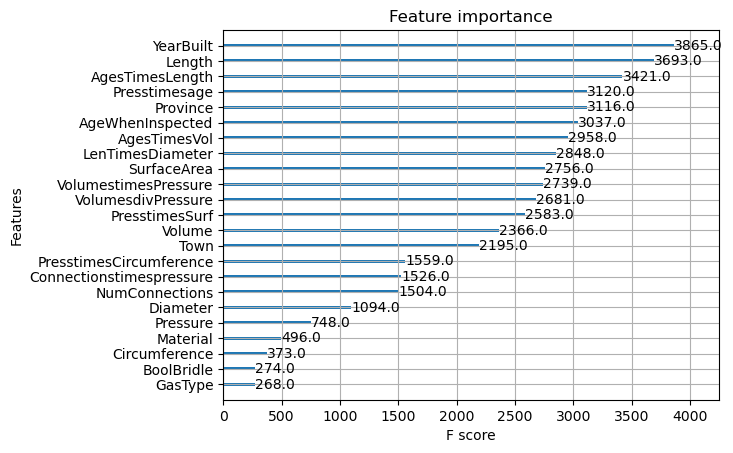

In [90]:
# PLOT THE IMPORTANCE
plot_importance(my_model)

In [91]:
# PREDICT PROBABILITIES AND SAVE FINAL SUBMISSION FILE
results_1 = my_model.predict_proba(sub)
results1df = pd.DataFrame(results_1[:,1])
ids = list(sub.index.values)  
results1df.index = ids
results1df.rename(columns={results1df.columns[0]:'Incidence'}, inplace=True)
results1df
results1df.to_csv("LASTSUB.csv", index=True)